In [15]:
import alpaca_trade_api as alpaca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Replace YOUR_API_KEY and YOUR_API_SECRET with your Alpaca API key and secret
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')

# Set the ticker symbol and time frame 
ticker = "XLY"
timeframe = "60Min"

# Set the start and end dates for the data
start_date = "2008-01-01T00:00:00-00:00"
end_date = "2022-12-31T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df

# Convert the data to a Pandas dataframe
df = pd.DataFrame(data)

df['HH21']=df['high'].rolling(21).max()
df['LL21']=df['low'].rolling(21).min()
df['50Pct']=0.5*(df['HH21']-df['LL21'])
df['61Pct']=(1-0.615)*(df['HH21']-df['LL21'])

df['50R']=df['close']/df['50Pct']
df['61R']=df['close']/df['61Pct']


# Calculate the 3 period moving average of the close
df['Mid']=(df['high']+df['low'])/2
df['3dH']=(df['high'].rolling(3).max().shift(-3))-df['close']#Shift this before subtracting close!!!!!!!!
df['3dL']=df['close']-(df['low'].rolling(3).min().shift(-3))
df['RewardRisk']=df['3dH']/df['3dL']

df['CPctile']=(df['high']-df['close'])/(df['high']-df['low'])
df['OPctile']=(df['high']-df['open'])/(df['high']-df['low'])

df['Range']=df['high']-df['low']
df['RangeT']=(df['Range']-df['Range'].rolling(30).mean())/df['Range'].rolling(30).std()

# Calculate the 20 period moving average of the close
#df['20MA'] = df['close'].rolling(20).mean()

#df['RewardRisk']=df['RewardRisk'].shift(-3)




df['close']=df['close'].pct_change()
df['Mid']=df['Mid'].pct_change()
df=df.drop(columns=['open','high','low','volume','trade_count','vwap','3dH','3dL','Range'])
           
df["Signal"] = 0.0
           



In [16]:
dfCopy=df.copy()

dfCopy=dfCopy.reset_index()

display(dfCopy)


for index, row in dfCopy.iterrows():
    
    if index>2 and index<4:
        print(dfCopy.loc[index-1, 'close'] )
        print(dfCopy.loc[index-2, 'close'])
       
        

timestamp     close    HH21   LL21  50Pct   61Pct  \
0     2015-12-01 14:00:00+00:00       NaN     NaN    NaN    NaN     NaN   
1     2015-12-01 15:00:00+00:00 -0.002455     NaN    NaN    NaN     NaN   
2     2015-12-01 16:00:00+00:00 -0.000861     NaN    NaN    NaN     NaN   
3     2015-12-01 17:00:00+00:00  0.003079     NaN    NaN    NaN     NaN   
4     2015-12-01 18:00:00+00:00 -0.001473     NaN    NaN    NaN     NaN   
...                         ...       ...     ...    ...    ...     ...   
17175 2022-12-30 17:00:00+00:00  0.000467  129.80  126.0   1.90  1.4630   
17176 2022-12-30 18:00:00+00:00 -0.004045  129.80  126.0   1.90  1.4630   
17177 2022-12-30 19:00:00+00:00 -0.001484  129.80  126.0   1.90  1.4630   
17178 2022-12-30 20:00:00+00:00  0.010169  129.80  126.0   1.90  1.4630   
17179 2022-12-30 21:00:00+00:00  0.005575  129.86  126.0   1.93  1.4861   

             50R        61R       Mid  RewardRisk   CPctile   OPctile  \
0            NaN        NaN       NaN    0.041237  0.204301  0.784946   
1            NaN        NaN -0.001291    1.466667  0.412371  0.020619   
2            NaN        NaN -0.000215         inf  0.555556  0.222222   
3            NaN        NaN  0.001662    0.950000  0.137931  1.000000   
4            NaN        NaN  0.000184   31.000000  0.636364  0.090909   
...          ...        ...       ...         ...       ...       ...   
17175  67.657895  87.867396  0.001247    0.735632  0.375000  0.500000   
17176  67.384211  87.511962 -0.002918    6.535714  0.606742  0.000000   
17177  67.284211  87.382092 -0.001483         NaN  0.756757  0.229730   
17178  67.968421  88.270677  0.004553         NaN  0.037175  0.996283   
17179  67.284974  87.383083  0.007217         NaN  0.000000  0.843373   

         RangeT  Signal  
0           NaN     0.0  
1           NaN     0.0  
2           NaN     0.0  
3           NaN     0.0  
4           NaN     0.0  
...         ...     ...  
17175 -0.392448     0.0  
17176  0.570273     0.0  
17177 -0.474929     0.0  
17178  1.372633     0.0  
17179  0.308437     0.0  

[17180 rows x 14 columns]

-0.0008613264427217437
-0.002454891371056811


In [19]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = 0.0
        
'''for index, row in df.iterrows():
    if row["RewardRisk"] >= 2:
       df.loc[index, "Signal"] = 1.0
    if row["RewardRisk"] < 2:
        df.loc[index,"Signal"] = 0.0'''
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["Mid"].shift(-1)
#df['RR']=df["RewardRisk"]

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(100)

close    HH21    LL21  50Pct    61Pct  \
timestamp                                                             
2022-12-19 13:00:00+00:00 -0.000446  136.79  133.05  1.870  1.43990   
2022-12-19 14:00:00+00:00 -0.008702  136.79  132.89  1.950  1.50150   
2022-12-19 15:00:00+00:00 -0.009304  136.79  132.02  2.385  1.83645   
2022-12-19 16:00:00+00:00 -0.003825  136.79  131.37  2.710  2.08670   
2022-12-19 17:00:00+00:00  0.004143  136.79  131.37  2.710  2.08670   
...                             ...     ...     ...    ...      ...   
2022-12-30 17:00:00+00:00  0.000467  129.80  126.00  1.900  1.46300   
2022-12-30 18:00:00+00:00 -0.004045  129.80  126.00  1.900  1.46300   
2022-12-30 19:00:00+00:00 -0.001484  129.80  126.00  1.900  1.46300   
2022-12-30 20:00:00+00:00  0.010169  129.80  126.00  1.900  1.46300   
2022-12-30 21:00:00+00:00  0.005575  129.86  126.00  1.930  1.48610   

                                 50R        61R       Mid  RewardRisk  \
timestamp                                                               
2022-12-19 13:00:00+00:00  71.898396  93.374540 -0.000892   -0.133117   
2022-12-19 14:00:00+00:00  68.348718  88.764569 -0.006920    0.094241   
2022-12-19 15:00:00+00:00  55.362683  71.899589 -0.005432    0.835821   
2022-12-19 16:00:00+00:00  48.536900  63.034936 -0.007797    1.990654   
2022-12-19 17:00:00+00:00  48.738007  63.296113  0.001101    0.433333   
...                              ...        ...       ...         ...   
2022-12-30 17:00:00+00:00  67.657895  87.867396  0.001247    0.735632   
2022-12-30 18:00:00+00:00  67.384211  87.511962 -0.002918    6.535714   
2022-12-30 19:00:00+00:00  67.284211  87.382092 -0.001483         NaN   
2022-12-30 20:00:00+00:00  67.968421  88.270677  0.004553         NaN   
2022-12-30 21:00:00+00:00  67.284974  87.383083  0.007217         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2022-12-19 13:00:00+00:00  0.000000  1.000000 -1.006120     0.0    -0.006920  
2022-12-19 14:00:00+00:00  0.660870  0.000000  0.540541     0.0    -0.005432  
2022-12-19 15:00:00+00:00  0.986111  0.131944  0.922375     0.0    -0.007797  
2022-12-19 16:00:00+00:00  0.753731  0.029851 -0.213996     1.0     0.001101  
2022-12-19 17:00:00+00:00  0.151515  0.969697 -0.137572     1.0     0.001574  
...                             ...       ...       ...     ...          ...  
2022-12-30 17:00:00+00:00  0.375000  0.500000 -0.392448     0.0    -0.002918  
2022-12-30 18:00:00+00:00  0.606742  0.000000  0.570273     0.0    -0.001483  
2022-12-30 19:00:00+00:00  0.756757  0.229730 -0.474929     1.0     0.004553  
2022-12-30 20:00:00+00:00  0.037175  0.996283  1.372633     1.0     0.007217  
2022-12-30 21:00:00+00:00  0.000000  0.843373  0.308437     NaN          NaN  

[100 rows x 14 columns]

In [20]:
df.tail(100)

close    HH21    LL21  50Pct    61Pct  \
timestamp                                                             
2022-12-19 13:00:00+00:00 -0.000446  136.79  133.05  1.870  1.43990   
2022-12-19 14:00:00+00:00 -0.008702  136.79  132.89  1.950  1.50150   
2022-12-19 15:00:00+00:00 -0.009304  136.79  132.02  2.385  1.83645   
2022-12-19 16:00:00+00:00 -0.003825  136.79  131.37  2.710  2.08670   
2022-12-19 17:00:00+00:00  0.004143  136.79  131.37  2.710  2.08670   
...                             ...     ...     ...    ...      ...   
2022-12-30 17:00:00+00:00  0.000467  129.80  126.00  1.900  1.46300   
2022-12-30 18:00:00+00:00 -0.004045  129.80  126.00  1.900  1.46300   
2022-12-30 19:00:00+00:00 -0.001484  129.80  126.00  1.900  1.46300   
2022-12-30 20:00:00+00:00  0.010169  129.80  126.00  1.900  1.46300   
2022-12-30 21:00:00+00:00  0.005575  129.86  126.00  1.930  1.48610   

                                 50R        61R       Mid  RewardRisk  \
timestamp                                                               
2022-12-19 13:00:00+00:00  71.898396  93.374540 -0.000892   -0.133117   
2022-12-19 14:00:00+00:00  68.348718  88.764569 -0.006920    0.094241   
2022-12-19 15:00:00+00:00  55.362683  71.899589 -0.005432    0.835821   
2022-12-19 16:00:00+00:00  48.536900  63.034936 -0.007797    1.990654   
2022-12-19 17:00:00+00:00  48.738007  63.296113  0.001101    0.433333   
...                              ...        ...       ...         ...   
2022-12-30 17:00:00+00:00  67.657895  87.867396  0.001247    0.735632   
2022-12-30 18:00:00+00:00  67.384211  87.511962 -0.002918    6.535714   
2022-12-30 19:00:00+00:00  67.284211  87.382092 -0.001483         NaN   
2022-12-30 20:00:00+00:00  67.968421  88.270677  0.004553         NaN   
2022-12-30 21:00:00+00:00  67.284974  87.383083  0.007217         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2022-12-19 13:00:00+00:00  0.000000  1.000000 -1.006120     0.0    -0.006920  
2022-12-19 14:00:00+00:00  0.660870  0.000000  0.540541     0.0    -0.005432  
2022-12-19 15:00:00+00:00  0.986111  0.131944  0.922375     0.0    -0.007797  
2022-12-19 16:00:00+00:00  0.753731  0.029851 -0.213996     1.0     0.001101  
2022-12-19 17:00:00+00:00  0.151515  0.969697 -0.137572     1.0     0.001574  
...                             ...       ...       ...     ...          ...  
2022-12-30 17:00:00+00:00  0.375000  0.500000 -0.392448     0.0    -0.002918  
2022-12-30 18:00:00+00:00  0.606742  0.000000  0.570273     0.0    -0.001483  
2022-12-30 19:00:00+00:00  0.756757  0.229730 -0.474929     1.0     0.004553  
2022-12-30 20:00:00+00:00  0.037175  0.996283  1.372633     1.0     0.007217  
2022-12-30 21:00:00+00:00  0.000000  0.843373  0.308437     NaN          NaN  

[100 rows x 14 columns]

In [21]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

'''for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())'''
    
for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())

Index(['close', 'HH21', 'LL21', '50Pct', '61Pct', '50R', '61R', 'Mid',
       'RewardRisk', 'CPctile', 'OPctile', 'RangeT', 'Signal', 'FutureSlope'],
      dtype='object')

:Scatter   [close]   (FutureSlope)

FutureSlope     close
FutureSlope     1.000000  0.311865
close           0.311865  1.000000

:Scatter   [HH21]   (FutureSlope)

FutureSlope      HH21
FutureSlope     1.000000 -0.012472
HH21           -0.012472  1.000000

:Scatter   [LL21]   (FutureSlope)

FutureSlope      LL21
FutureSlope     1.000000 -0.012829
LL21           -0.012829  1.000000

:Scatter   [50Pct]   (FutureSlope)

FutureSlope     50Pct
FutureSlope     1.000000 -0.001778
50Pct          -0.001778  1.000000

:Scatter   [61Pct]   (FutureSlope)

FutureSlope     61Pct
FutureSlope     1.000000 -0.001778
61Pct          -0.001778  1.000000

:Scatter   [50R]   (FutureSlope)

FutureSlope       50R
FutureSlope     1.000000  0.003862
50R             0.003862  1.000000

:Scatter   [61R]   (FutureSlope)

FutureSlope       61R
FutureSlope     1.000000  0.003862
61R             0.003862  1.000000

:Scatter   [Mid]   (FutureSlope)

FutureSlope       Mid
FutureSlope     1.000000  0.101084
Mid             0.101084  1.000000

:Scatter   [RewardRisk]   (FutureSlope)

FutureSlope  RewardRisk
FutureSlope     1.000000    0.012215
RewardRisk      0.012215    1.000000

:Scatter   [CPctile]   (FutureSlope)

FutureSlope   CPctile
FutureSlope     1.000000 -0.392084
CPctile        -0.392084  1.000000

:Scatter   [OPctile]   (FutureSlope)

FutureSlope   OPctile
FutureSlope     1.000000  0.201207
OPctile         0.201207  1.000000

:Scatter   [RangeT]   (FutureSlope)

FutureSlope    RangeT
FutureSlope     1.000000 -0.029008
RangeT         -0.029008  1.000000

:Scatter   [Signal]   (FutureSlope)

FutureSlope    Signal
FutureSlope     1.000000  0.609938
Signal          0.609938  1.000000

:Scatter   [FutureSlope]   (FutureSlope)

FutureSlope  FutureSlope
FutureSlope          1.0          1.0
FutureSlope          1.0          1.0

In [23]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

1.0    8043
0.0    7259
Name: Signal, dtype: int64

In [24]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['50Pct','61Pct','RangeT','OPctile','CPctile']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=71)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

2015-12-04 17:00:00+00:00
2021-11-04 17:00:00+00:00


50Pct    61Pct    RangeT   OPctile   CPctile
timestamp                                                              
2015-12-04 17:00:00+00:00  1.165  0.89705  1.141032  0.875156  0.035721
2015-12-04 18:00:00+00:00  1.060  0.81620 -0.305574  0.923077  0.461538
2015-12-04 19:00:00+00:00  1.055  0.81235 -0.028902  0.612903  0.009032
2015-12-04 20:00:00+00:00  1.045  0.80465 -0.489430  0.318182  0.545455
2015-12-04 21:00:00+00:00  0.995  0.76615 -0.809420  0.133333  0.133333

50Pct     61Pct    RangeT   OPctile   CPctile
timestamp                                                                
2021-11-04 13:00:00+00:00  3.4025  2.619925  1.440936  0.842424  0.121212
2021-11-04 14:00:00+00:00  3.8100  2.933700  1.036622  0.908759  0.284672
2021-11-04 15:00:00+00:00  3.7450  2.883650  1.140058  0.006711  0.147651
2021-11-04 16:00:00+00:00  3.7450  2.883650 -0.334693  0.788991  0.238532
2021-11-04 17:00:00+00:00  3.8250  2.945250  0.032247  0.556962  0.392405

In [8]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71      1435
         1.0       0.69      0.77      0.73      1380

    accuracy                           0.72      2815
   macro avg       0.72      0.72      0.72      2815
weighted avg       0.72      0.72      0.72      2815



In [9]:
4991/9151

0.5454048737842858

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


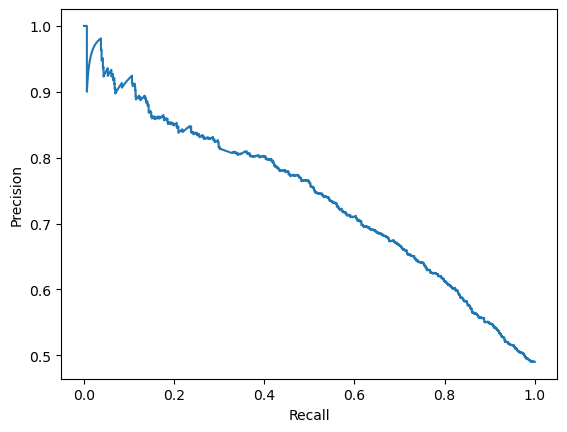

In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [11]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

0.6631759913513577
2761
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1435
         1.0       0.49      0.99      0.66      1380

    accuracy                           0.49      2815
   macro avg       0.24      0.50      0.33      2815
weighted avg       0.24      0.49      0.32      2815



In [12]:
X_test

50Pct     61Pct    RangeT   OPctile   CPctile
timestamp                                                                
2021-11-04 18:00:00+00:00  3.8250  2.945250  0.113915  0.267442  0.872093
2021-11-04 19:00:00+00:00  3.8250  2.945250 -0.449440  0.553191  0.446809
2021-11-04 20:00:00+00:00  3.7500  2.887500 -1.161977  0.000000  1.000000
2021-11-05 11:00:00+00:00  3.8800  2.987600  0.253392  0.000000  1.000000
2021-11-05 12:00:00+00:00  4.4581  3.432737  1.383018  0.993448  0.731359
...                           ...       ...       ...       ...       ...
2022-12-30 14:00:00+00:00  1.9000  1.463000  0.472443  0.562130  0.278107
2022-12-30 15:00:00+00:00  1.9000  1.463000  0.314869  0.610390  0.590909
2022-12-30 16:00:00+00:00  1.9000  1.463000 -0.201396  0.300000  0.200000
2022-12-30 17:00:00+00:00  1.9000  1.463000 -0.392448  0.500000  0.375000
2022-12-30 18:00:00+00:00  1.9000  1.463000  0.570273  0.000000  0.606742

[2815 rows x 5 columns]

In [13]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    

0.01
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1435
         1.0       0.49      1.00      0.66      1380

    accuracy                           0.49      2815
   macro avg       0.25      0.50      0.33      2815
weighted avg       0.24      0.49      0.32      2815

0.02
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1435
         1.0       0.49      1.00      0.66      1380

    accuracy                           0.49      2815
   macro avg       0.25      0.50      0.33      2815
weighted avg       0.24      0.49      0.32      2815

0.03
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1435
         1.0       0.49      1.00      0.66      1380

    accuracy                           0.49      2815
   macro avg       0.25      0.50      0.33      2815
weighted avg       0.24      0.49      0.32      2815

0.04

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/op

              precision    recall  f1-score   support

         0.0       0.59      0.92      0.72      1435
         1.0       0.81      0.35      0.48      1380

    accuracy                           0.64      2815
   macro avg       0.70      0.63      0.60      2815
weighted avg       0.70      0.64      0.61      2815

0.5
              precision    recall  f1-score   support

         0.0       0.59      0.92      0.72      1435
         1.0       0.81      0.33      0.47      1380

    accuracy                           0.63      2815
   macro avg       0.70      0.63      0.59      2815
weighted avg       0.70      0.63      0.60      2815

0.51
              precision    recall  f1-score   support

         0.0       0.58      0.94      0.72      1435
         1.0       0.82      0.29      0.43      1380

    accuracy                           0.62      2815
   macro avg       0.70      0.61      0.57      2815
weighted avg       0.70      0.62      0.58      2815

0.52
     

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/op